In [1]:
import tensorflow as tf

2025-02-20 07:11:16.341052: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-20 07:11:16.700269: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740035476.871098     638 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740035476.916219     638 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-20 07:11:17.289506: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Check if your Tensoflow is enabling the GPU


In [ ]:

len(tf.config.list_physical_devices('GPU'))

1

In [4]:
import tensorflow as tf
from tensorflow.keras import models,layers

In [5]:
import matplotlib.pyplot as plt

In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
CLASSES = 3
EPOCHS = 50

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


I0000 00:00:1740035500.464021     638 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [9]:
class_names = dataset.class_names

In [10]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [11]:
len(dataset)

68

In [12]:
for image_batch,label_batch in dataset.take(1):
    print(len(image_batch))
    print(len(label_batch))

32
32


2025-02-20 07:11:47.967994: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2025-02-20 07:11:48.601856: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


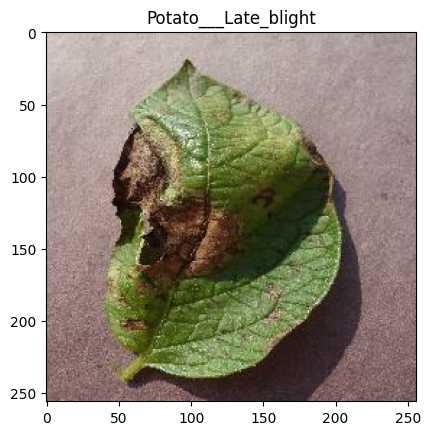

In [13]:
for image_batch,label_batch in dataset.take(1):
    plt.title(class_names[label_batch[0]])
    plt.imshow(image_batch[0].numpy().astype("uint8"))

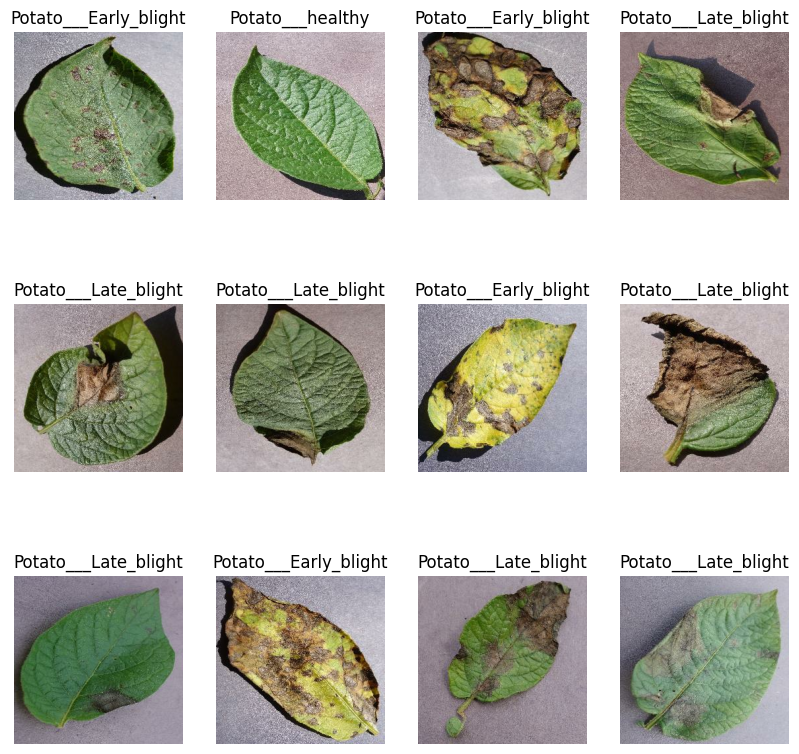

In [14]:
plt.figure(figsize = (10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.title(class_names[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

In [ ]:
def get_data_partitions(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    ds_len = len(ds)  
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)  
    
    train_size = int(train_split * ds_len)
    val_size = int(val_split * ds_len)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)
    
    return train_ds, val_ds, test_ds


In [16]:
train_ds,val_ds,test_ds = get_data_partitions(dataset)

In [17]:
len(train_ds)

54

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [19]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    tf.keras.layers.Rescaling(1/255)
])

In [20]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
])


In [21]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(CLASSES,activation="softmax"),    
])
model.build(input_shape=input_shape)

/home/prash07/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(
    optimizer="adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [24]:
tf.config.optimizer.set_jit(False)


In [24]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


I0000 00:00:1740035645.657344     748 cuda_dnn.cc:529] Loaded cuDNN version 90300


54/54 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - accuracy: 0.4824 - loss: 0.9206 - val_accuracy: 0.5208 - val_loss: 0.8343
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.6267 - loss: 0.7504 - val_accuracy: 0.8750 - val_loss: 0.3577
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.7800 - loss: 0.5009 - val_accuracy: 0.7188 - val_loss: 0.6050
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 74ms/step - accuracy: 0.8905 - loss: 0.2929 - val_accuracy: 0.9167 - val_loss: 0.2225
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - accuracy: 0.9256 - loss: 0.2105 - val_accuracy: 0.8229 - val_loss: 0.4448
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.9442 - loss: 0.1892 - val_accuracy: 0.9323 - val_loss: 0.1462
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 82ms/step - accuracy: 0.9631 - loss: 0.0955 - val_accuracy: 0.8490 - val_loss: 0.4374
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.9540 - loss: 0.1019 - val_accuracy: 0.9531 - val_loss: 

In [25]:
scores = model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.9953 - loss: 0.0143 


In [26]:
scores

[0.012631620280444622, 0.99609375]

In [27]:
history

In [28]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [29]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [30]:
history.history['accuracy']

[0.5,
 0.7002314925193787,
 0.8061342835426331,
 0.8883101940155029,
 0.9305555820465088,
 0.9473379850387573,
 0.9606481194496155,
 0.9618055820465088,
 0.9571759104728699,
 0.9693287014961243,
 0.9797453880310059,
 0.9612268805503845,
 0.9693287014961243,
 0.9785879850387573,
 0.9809027910232544,
 0.9809027910232544,
 0.9484953880310059,
 0.984375,
 0.9832175970077515,
 0.9774305820465088,
 0.9837962985038757,
 0.984375,
 0.9872685074806213,
 0.9913194179534912,
 0.9837962985038757,
 0.9936342835426331,
 0.9780092835426331,
 0.9849537014961243,
 0.9895833134651184,
 0.9826388955116272,
 0.9913194179534912,
 0.9890046119689941,
 0.9918981194496155,
 0.9878472089767456,
 0.9901620149612427,
 0.9942129850387573,
 0.9785879850387573,
 0.9901620149612427,
 0.9907407164573669,
 0.9936342835426331,
 0.9820601940155029,
 0.9907407164573669,
 0.9965277910232544,
 0.9947916865348816,
 0.9918981194496155,
 0.9959490895271301,
 0.9936342835426331,
 0.9693287014961243,
 0.9832175970077515,
 0.990

In [31]:
len(history.history['accuracy'])

50

In [32]:
history.history['val_accuracy']

[0.5208333134651184,
 0.875,
 0.71875,
 0.9166666865348816,
 0.8229166865348816,
 0.9322916865348816,
 0.8489583134651184,
 0.953125,
 0.859375,
 0.90625,
 0.9270833134651184,
 0.8854166865348816,
 0.9635416865348816,
 0.9114583134651184,
 0.828125,
 0.9635416865348816,
 0.9583333134651184,
 0.96875,
 0.9270833134651184,
 0.9791666865348816,
 0.9479166865348816,
 0.9427083134651184,
 0.9739583134651184,
 0.9635416865348816,
 0.9635416865348816,
 0.9635416865348816,
 0.9010416865348816,
 0.9739583134651184,
 0.8125,
 0.9791666865348816,
 0.8958333134651184,
 0.9322916865348816,
 0.984375,
 0.96875,
 0.9739583134651184,
 0.984375,
 0.9427083134651184,
 0.9739583134651184,
 0.984375,
 0.9947916865348816,
 0.9947916865348816,
 0.9791666865348816,
 0.9947916865348816,
 0.9739583134651184,
 0.984375,
 0.9895833134651184,
 0.96875,
 0.9583333134651184,
 0.9947916865348816,
 0.9895833134651184]

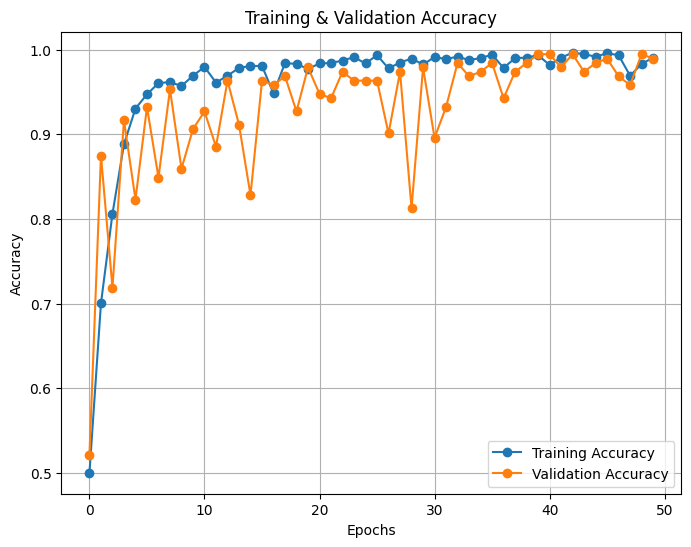

In [ ]:
#plotting:
history_dict = history.history  

accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(accuracy, label='Training Accuracy', marker='o')
plt.plot(val_accuracy, label='Validation Accuracy', marker='o')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()
plt.grid()
plt.show()


First Image to predict
Actual Label :  Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
Prediction :  Potato___Late_blight


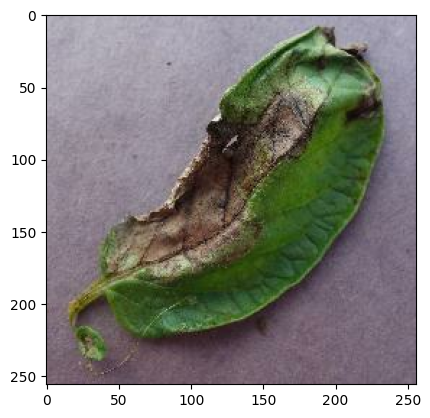

In [43]:
import numpy as np
#checking:
for image_batch, label_batch in test_ds.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label : ",class_names[first_label])

    batch_prediction = model.predict(image_batch)
    print("Prediction : ",class_names[np.argmax(batch_prediction[0])])
    

In [50]:
def getPrediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[1].numpy())
    img_array = tf.expand_dims(img_array,0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


2025-02-20 08:02:32.178729: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


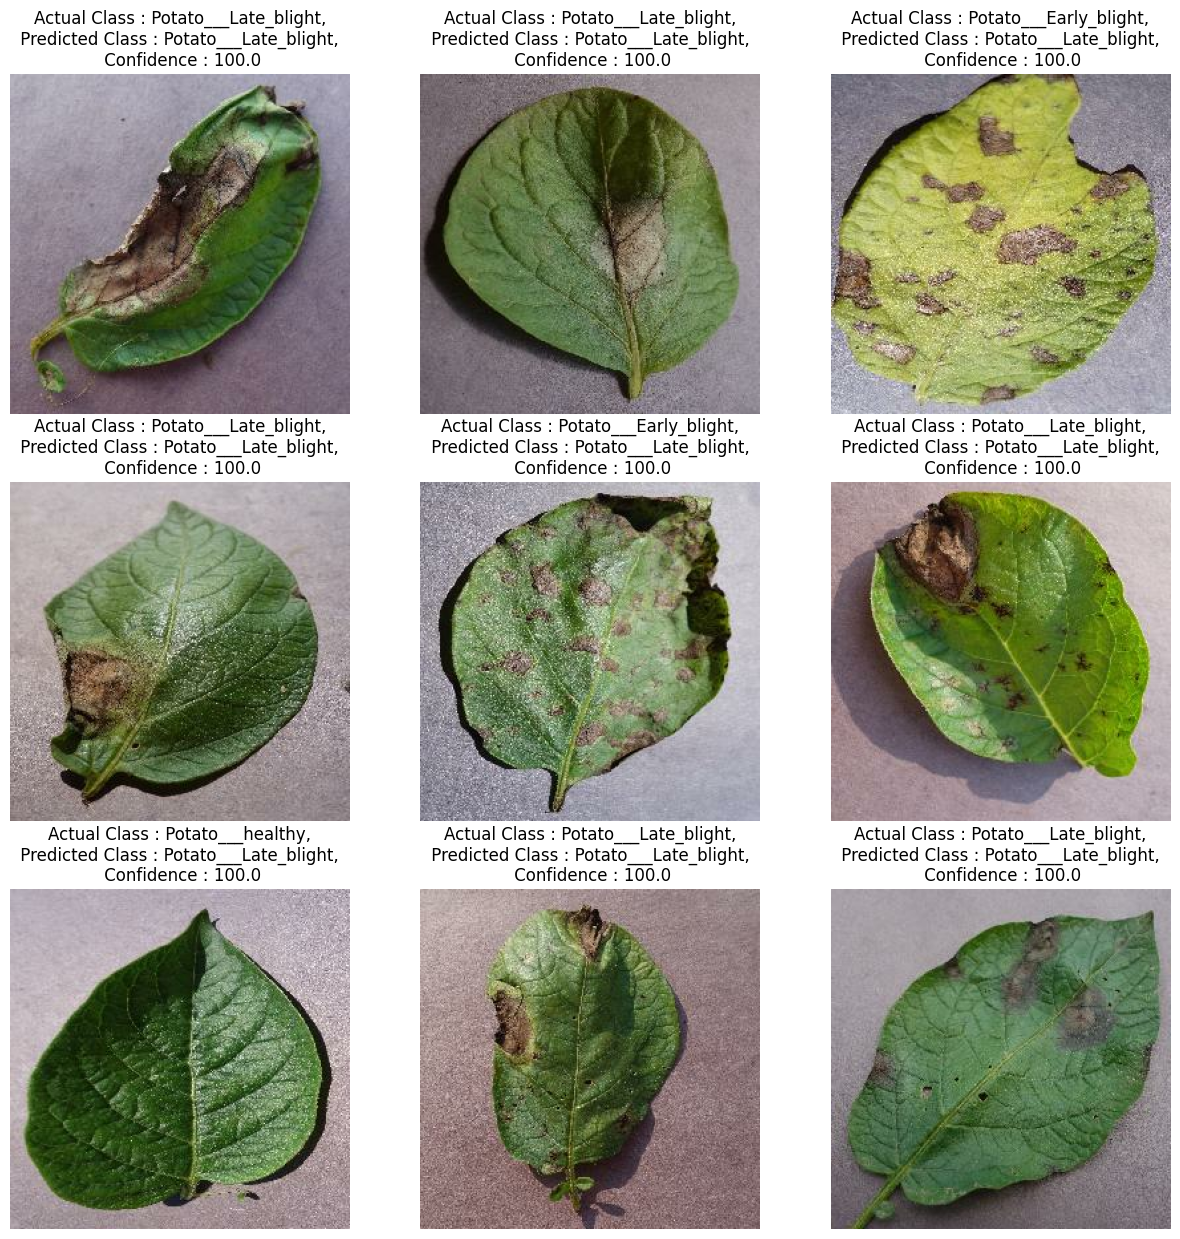

In [54]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
     for i in range(9):
         ax = plt.subplot(3,3,i+1)
         plt.imshow(images[i].numpy().astype('uint8'))
         plt.axis("off")

         predicted_class , confidence = getPrediction(model,images[i].numpy())
         actual_class = class_names[labels[i]]
         plt.title(f"Actual Class : {actual_class},\n Predicted Class : {predicted_class}, \n Confidence : {confidence}")

In [58]:
model_version = 1.0
model.export(f"./model/{model_version}")

INFO:tensorflow:Assets written to: ./model/1.0/assets


INFO:tensorflow:Assets written to: ./model/1.0/assets


Saved artifact at './model/1.0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 3), dtype=tf.float32, name=None)
Captures:
  140238857819584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238857820464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590115328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590114800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590139376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590139200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590165936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590165760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590167872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590167696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140238590178048: Te